This is a learning notebook. Just want to type along when reading Chapter 3 of the book Hands-On Machine Learning cited below.
<br>
Credit of codes below: Aurlien Gron. 2017. Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (1st. ed.). O’Reilly Media, Inc.

In [19]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [7]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


## Explore data

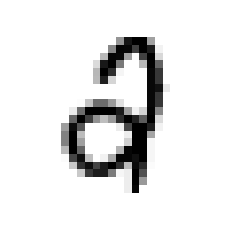

2


In [25]:
# Visualize some pictures
eg_digit_image = train.iloc[10000, 1:].values.reshape(28, 28)
eg_digit_label = train.iloc[10000, 0]
plt.imshow(eg_digit_image, cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')
plt.show()
print(eg_digit_label)

In [41]:
# shuffle train data
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train.iloc[:, 1:].values, train.iloc[:, 0].values, test_size = 0.2, random_state = 777)
shuffle_index = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

## Binary classification on digit 5

In [42]:
y_train_5 = (y_train == 5)
y_valid_5 = (y_valid == 5)

In [43]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

In [48]:
some_digits = train[train['label'] == 5].drop(columns = 'label').values
sgd_clf.predict(some_digits)

array([ True,  True,  True, ..., False,  True,  True])

In [50]:
# DIY cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [52]:
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9604464285714286
0.9496428571428571
0.9661607142857143


In [53]:
# use cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.96044643, 0.94964286, 0.96616071])

In [54]:
# cross_val_predict, confusion_matrix, precision and recall
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3)

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[30376,   208],
       [ 1178,  1838]])

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score
print('Precision: ', precision_score(y_train_5, y_train_pred))
print('Recall: ', recall_score(y_train_5, y_train_pred))
print('F1: ', f1_score(y_train_5, y_train_pred))

Precision:  0.8983382209188661
Recall:  0.6094164456233422
F1:  0.7261951797708416


In [57]:
recall_score(y_train_5, y_train_pred)

0.6094164456233422

In [63]:
y_scores = sgd_clf.decision_function([some_digits[0]])
y_scores
threshold = 200000
y_some_digits_pred = (y_scores > threshold)
y_some_digits_pred

array([False])

In [64]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv = 3, method = 'decision_function')

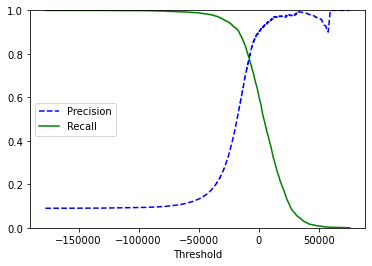

In [65]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'center left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [66]:
precisions

array([0.08991176, 0.08988463, 0.08988731, ..., 1.        , 1.        ,
       1.        ])

(0.0, 1.0)

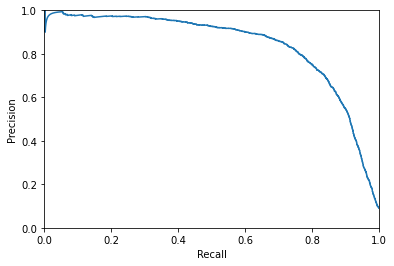

In [68]:
plt.plot(recalls, precisions)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.ylim([0, 1])
plt.xlim([0, 1])

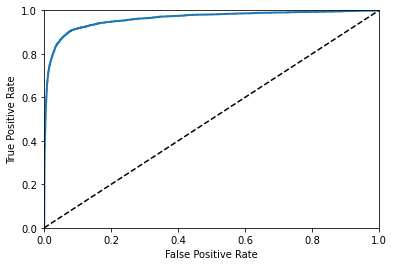

In [69]:
# roc curve
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

In [70]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9617944964028277

In [71]:
# compare RF to SDG
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv = 3, method = 'predict_proba')

In [72]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

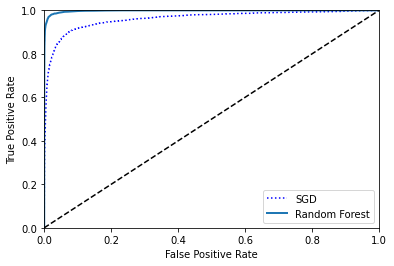

In [73]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc = 'lower right')

In [75]:
y_label_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv = 3)
print('AUC: ', roc_auc_score(y_train_5, y_scores_forest))
print('Precision: ', precision_score(y_train_5, y_label_forest))
print('Recall: ', recall_score(y_train_5, y_label_forest))

AUC:  0.9979663240813144
Precision:  0.9901380670611439
Recall:  0.8322281167108754


## Multiclass classification

In [76]:
# use binary classifier for multiclass classification - sklearn automatically detects this
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digits[0]])

array([5])

In [79]:
sgd_clf.decision_function([some_digits[0]])

array([[-48666.21271592, -71345.59804242, -42562.09837719,
        -10682.9921829 ,  -5409.08471158,  14013.41409302,
        -69715.65124151, -55024.00239643,  -7874.04229668,
        -15150.72822555]])

In [80]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [82]:
# force SGD to use OvO strategy
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict([some_digits[0]])

array([5])

In [83]:
len(ovo_clf.estimators_)

45

In [84]:
# random forest
forest_clf.fit(x_train, y_train)
forest_clf.predict([some_digits[0]])

array([5])

In [85]:
forest_clf.predict_proba([some_digits[0]])

array([[0.  , 0.  , 0.  , 0.03, 0.01, 0.93, 0.  , 0.01, 0.  , 0.02]])

In [86]:
# evaluate the classifiers
cross_val_score(sgd_clf, x_train, y_train, cv = 3, scoring = 'accuracy')

array([0.87410714, 0.86607143, 0.86660714])

In [88]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv = 3, scoring = 'accuracy')

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90866071, 0.90428571, 0.90866071])

In [89]:
# error analysis
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv = 3)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [90]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3147,    0,   10,    8,    5,   39,   27,    4,   61,    3],
       [   0, 3569,   20,   22,    1,   26,    5,    3,   68,    7],
       [  18,   24, 2933,   62,   36,   23,   35,   29,  140,    8],
       [  11,   17,   75, 3080,    2,  125,   22,   21,  134,   42],
       [   6,   10,   28,   11, 2916,    6,   17,   16,   88,  127],
       [  22,    7,   21,  110,   37, 2543,   49,   13,  169,   45],
       [  19,    8,   30,    1,   24,   52, 3120,    3,   52,    0],
       [  13,   12,   39,   21,   22,    2,    3, 3234,   34,  148],
       [  15,   38,   26,   70,    6,   69,   15,    8, 2982,   44],
       [  12,   14,   17,   40,  103,   26,    0,  102,  115, 2958]])

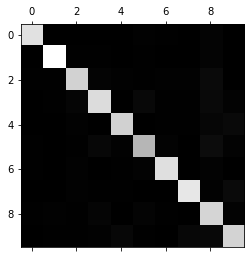

In [91]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

In [92]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

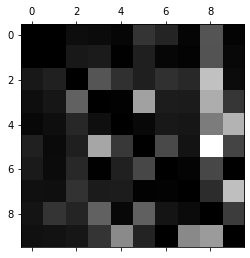

In [93]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

## Multilabel classification

In [95]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [96]:
knn_clf.predict([some_digits[0]])

array([[False,  True]])

In [97]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.9717867622924914

In [98]:
f1_score(y_multilabel, y_train_knn_pred, average = 'weighted')

0.9735321850447172

## Multioutput classification

In [100]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_valid), 784))
x_valid_mod = x_valid + noise
y_train_mod = x_train
y_valid_mod = x_valid

In [105]:
x_train_mod[0].shape

(784,)

(-0.5, 27.5, 27.5, -0.5)

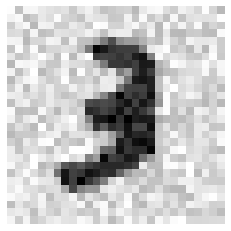

In [106]:
plt.imshow(x_train_mod[0].reshape(28, 28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

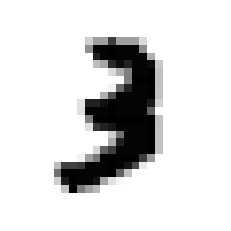

In [107]:
plt.imshow(x_train[0].reshape(28, 28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

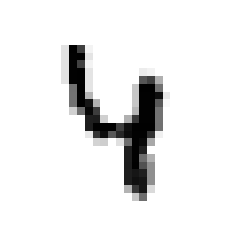

In [109]:
plt.imshow(x_valid[0].reshape(28, 28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

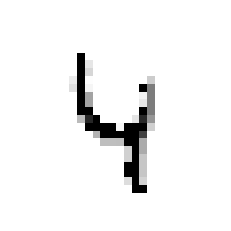

In [108]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_valid_mod[0]])
plt.imshow(clean_digit.reshape(28, 28), cmap = mpl.cm.binary, interpolation = 'nearest')
plt.axis('off')

Based on what's covered in this chapter, I just want to create a really simple submission and serve as a benchmark for improvements in later submissions.

In [110]:
xTrain = train.iloc[:, 1:]
yTrain = train.iloc[:, 0]

In [111]:
xTrainScaled = scaler.fit_transform(xTrain)

In [112]:
xTestScaled = scaler.transform(test)

In [116]:
knn = KNeighborsClassifier(weights = 'distance', n_neighbors = 4)
knn.fit(xTrainScaled, yTrain)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [117]:
testPred = knn.predict(xTestScaled)

In [135]:
result = pd.concat([pd.DataFrame(np.arange(0, len(test)) + 1), pd.DataFrame(testPred)], axis = 1)
result.columns = ['ImageId', 'Label']
result.to_csv('digit_recognizer_20200705.csv', index = False)

In [136]:
result

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
